In [1]:
import cv2
import os
import re
import matplotlib.pyplot as plt
import ants

In [2]:
img_dir = '../keerthi_data/BFIW_processed/'
imgs = os.listdir(img_dir)
regex = re.compile(r".*-SE_(\d+)_processed.jpg")
imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
imgs_ordered = {}
for img in imgs:
    section_num = int(regex.match(img).group(1))
    section_id = str(section_num)
    section_id_digits = len(section_id)
    if section_id_digits <4:
        section_id = '0'*(4-section_id_digits) + str(section_num)
    imgs_ordered[section_id] = os.path.join(img_dir, img)

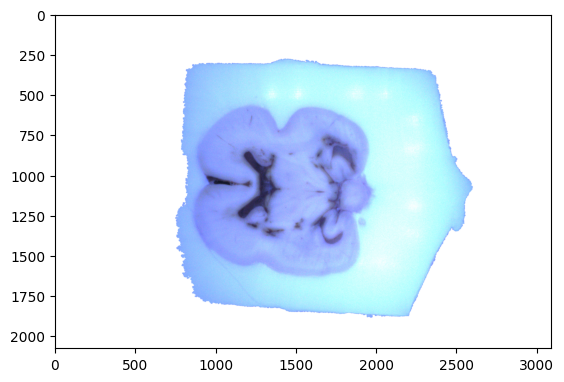

In [3]:
import numpy as np
import scipy
img_path = img_dir + imgs[1200]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = np.stack((img[:,:,0]/ np.linalg.norm(img[:,:,0]),(img[:,:,1]/np.linalg.norm(img[:,:,1]))))
# img = np.stack([scipy.ndimage.gaussian_filter(img[:,:,0],1) ,scipy.ndimage.gaussian_filter(img[:,:,1],1)])
img = np.stack([img[:,:,0], img[:,:,1]])
img = np.min(img.clip(100,150),0)
# return img
# sample_img = read_image_gray(img_dir + imgs[1606])
sample_ants = ants.from_numpy(img)
sample_mask = sample_ants.get_mask(cleanup=4)
mask = sample_mask.numpy().astype(np.uint8)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
blank_white = np.ones_like(img) * 255
for i in range(3):
    blank_white[:,:,i][mask==1] = img[:,:,i][mask==1]
# lookUpTable = np.empty((1,256), np.uint8)
# for i in range(256):
#     lookUpTable[0,i] = np.clip(pow(i / 255.0, 1) * 255.0, 0, 255)

# res = cv2.LUT(blank_white.copy(), lookUpTable)
# plt.imshow(res[500:1500,750:1900, :])
plt.imshow(blank_white)
# plt.imshow(blank_white[300:1750, 700: 2300,:])

In [4]:
import ants
import numpy as np
import cv2
from skimage import exposure
import colour
from skimage import color as skcolor
import os

def read_image_gray(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = np.stack((img[:,:,0]/ np.linalg.norm(img[:,:,0]),(img[:,:,1]/np.linalg.norm(img[:,:,1]))))
    # img = np.stack([img[:,:,0],img[:,:,1]])
    img = np.stack([img[:,:,0], img[:,:,1]])
    img = np.min(img.clip(100,150),0)
    return img

def read_image_rgb(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# img_idx = 1606
def save_processed(img_idx, img_dir=img_dir, imgs=imgs_ordered, save_path='/storage/valis_reg/cropped_imgs'):
    img_path = imgs[img_idx]
    sample_img = read_image_gray(img_path)
    sample_ants = ants.from_numpy(sample_img)
    sample_mask = sample_ants.get_mask(cleanup=3)
    mask = sample_mask.numpy().astype(np.uint8)
    img = read_image_rgb(img_path)
    blank_white = np.ones_like(img) * 255 # type: ignore
    for i in range(3):
        blank_white[:,:,i][mask==1] = img[:,:,i][mask==1]
    # lookUpTable = np.empty((1,256), np.uint8)
    # for i in range(256):
    #     lookUpTable[0,i] = np.clip(pow(i / 255.0, 0.9) * 255.0, 0, 255)
    # res = cv2.LUT(blank_white.copy(), lookUpTable)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    # find the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])
    # crop the image to the bounding box
    h = min(h, 1500)
    w = min(w, 1700)
    blank_white = blank_white[y:y+h, x:x+w]
    save_path = '/storage/valis_reg/cropped_imgs'
    plt.imsave(os.path.join(save_path, f'{img_idx}.jpg'), blank_white)

In [13]:
from joblib import Parallel, delayed
from tqdm import tqdm

stored = Parallel(n_jobs=32)(delayed(save_processed)(img_idx) for img_idx in tqdm(list(imgs_ordered.keys())[1500:]))

100%|██████████| 1129/1129 [01:47<00:00, 10.51it/s]


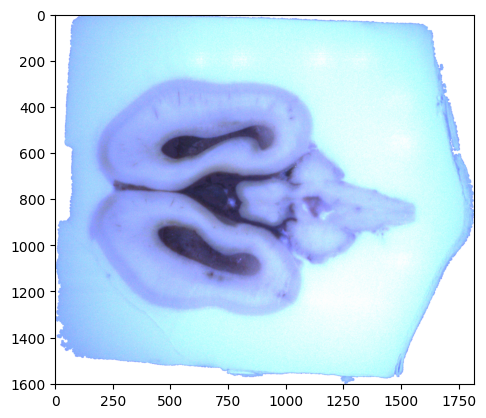

In [461]:

plt.imshow(blank_white)

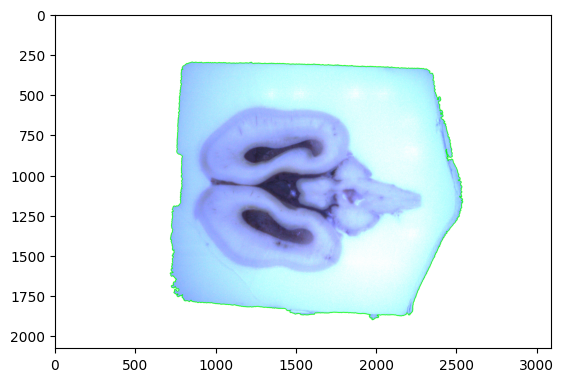

In [459]:
bn = cv2.drawContours(blank_white.copy(), contours, -1, (0,255,0), 3)
plt.imshow(bn)

In [362]:
import colour

In [388]:
from skimage import exposure
import colour
from skimage import color as skcolor

def standardize_colorfulness(img, c=0.4, h=0):
    """Give image constant colorfulness and hue

    Image is converted to cylindrical CAM-16UCS assigned a constant
    hue and colorfulness, and then coverted back to RGB.

    Parameters
    ----------
    img : ndarray
        Image to be processed
    c : int
        Colorfulness
    h : int
        Hue, in radians (-pi to pi)

    Returns
    -------
    rgb2 : ndarray
        `img` with constant hue and colorfulness

    """
    # Convert to CAM16 #
    eps = np.finfo("float").eps
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        if 1 < img.max() <= 255 and np.issubdtype(img.dtype, np.integer):
            cam = colour.convert(img/255 + eps, 'sRGB', 'CAM16UCS')
        else:
            cam = colour.convert(img + eps, 'sRGB', 'CAM16UCS')

    lum = cam[..., 0]
    cc = np.full_like(lum, c)
    hc = np.full_like(lum, h)
    new_a, new_b = cc * np.cos(hc), cc * np.sin(hc)
    new_cam = np.dstack([lum, new_a+eps, new_b+eps])
    with colour.utilities.suppress_warnings(colour_usage_warnings=True):
        rgb2 = colour.convert(new_cam, 'CAM16UCS', 'sRGB')
        rgb2 -= eps

    rgb2 = (np.clip(rgb2, 0, 1)*255).astype(np.uint8)
    std_g = skcolor.rgb2gray(rgb2)

    std_g = exposure.equalize_adapthist(rgb2/255)

    processed_img = exposure.rescale_intensity(std_g, in_range="image", out_range=(0, 255)).astype(np.uint8)

    return processed_img

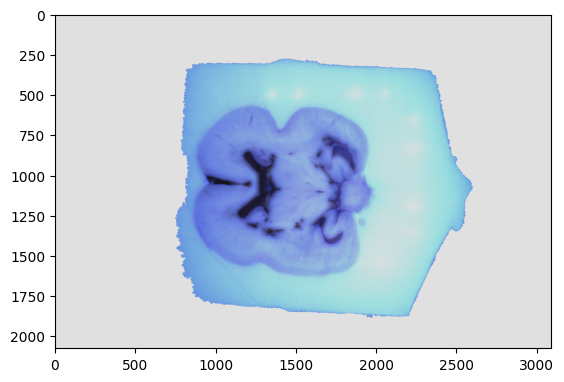

In [454]:
import skimage
img = blank_white.copy()
r_image = img[:, :, 0]
g_image = img[:, :, 1]
b_image = img[:, :, 2]
r_image_eq = exposure.equalize_adapthist(r_image)
r_image_eq = exposure.equalize_adapthist(g_image)
b_image_eq = exposure.equalize_adapthist(b_image)

image_eq = cv2.merge((r_image_eq, r_image_eq, b_image_eq))
# img[:,:, 2] = np.clip(img[:,:, 2], 0,192)
# img[:,:, 1] = np.clip(img[:,:, 1], 0, 230)
# img[:,:, 1] = np.clip(img[:,:, 1], 0, 240)
img_gamma = skimage.exposure.adjust_sigmoid(img, cutoff=0.6, gain=5, inv=False)
plt.imshow(img_gamma)

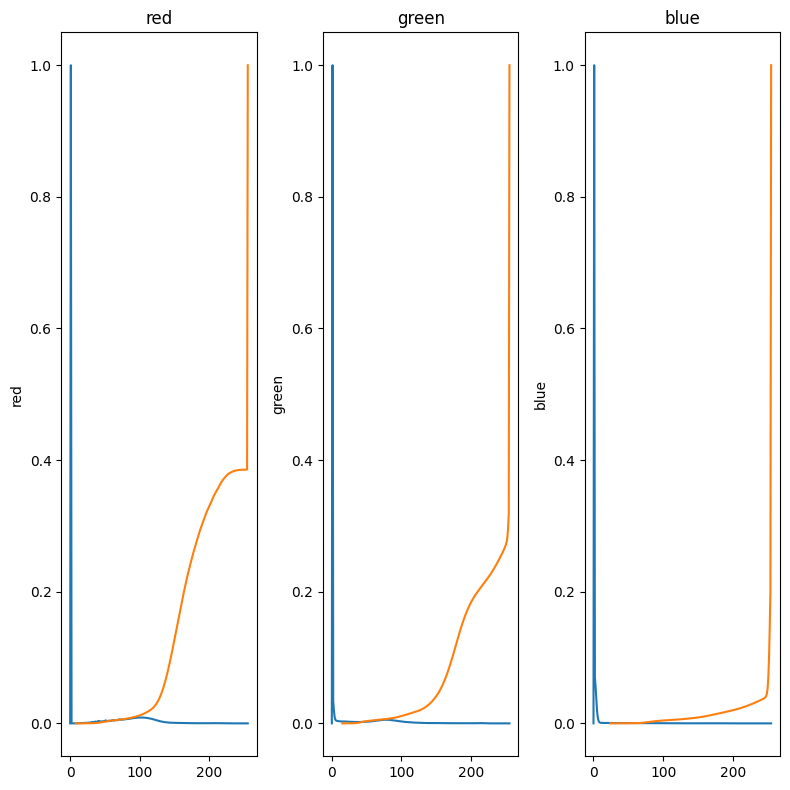

In [456]:
from skimage import exposure

image = blank_white.copy()
image = (image*255).astype(np.uint8)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))


# for img in enumerate((image)):
for c, c_color in enumerate(('red', 'green', 'blue')):
    img_hist, bins = exposure.histogram(image[..., c], source_range='dtype')
    axes[c].plot(bins, img_hist / img_hist.max())
    img_cdf, bins = exposure.cumulative_distribution(img[..., c])
    axes[c].plot(bins, img_cdf)
    axes[c].set_ylabel(c_color)
    axes[ c].set_title(c_color)

plt.tight_layout()
plt.show()

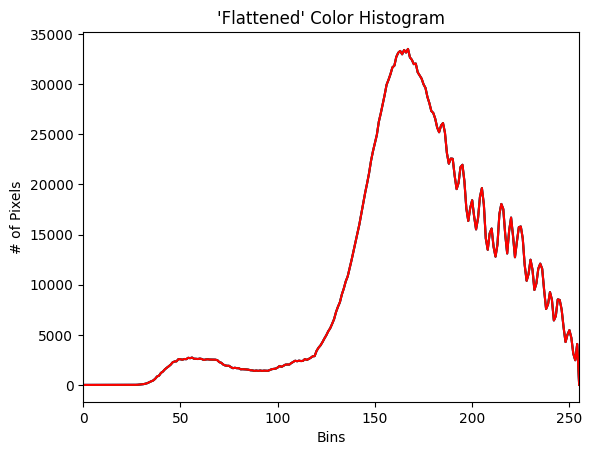

In [336]:
img_uint8 = (img).astype(np.uint8)
# np.std(img[:,:,2])
chans = cv2.split(img_uint8)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
for (chan, color) in zip(chans, colors):
# 	# create a histogram for the current channel and plot it
    hist = cv2.calcHist([img_uint8], [0], mask, [256], [0, 255])
    plt.plot(hist, color=color)
    plt.xlim([0, 255])
    # plt.imshow(res)

(0.0, 150.0)

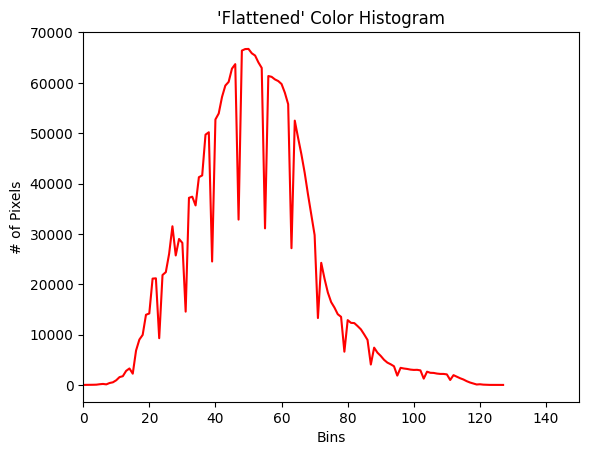

In [286]:
# img = read_image_rgb(img_dir + imgs[40])
img_uint8 = (img*255).astype(np.uint8)
# np.std(img[:,:,2])
# chans = cv2.split(img)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
# for (chan, color) in zip(chans, colors):
# 	# create a histogram for the current channel and plot it
hist = cv2.calcHist([img_uint8], [0], mask, [128], [0, 240])
plt.plot(hist, color="r")
plt.xlim([0, 150])

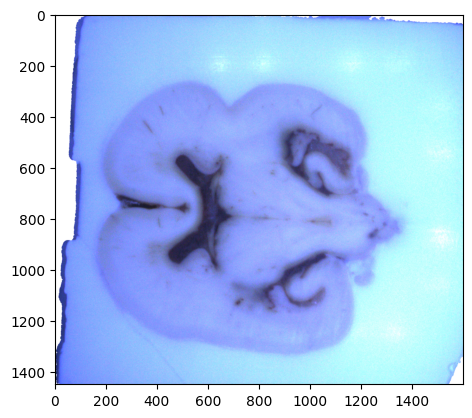

In [281]:

img = read_image_rgb(img_dir + imgs[1300])
blank_white = np.ones_like(img) * 255
for i in range(3):
    blank_white[:,:,i][mask==1] = img[:,:,i][mask==1]
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, 1) * 255.0, 0, 255)

res = cv2.LUT(blank_white.copy(), lookUpTable)
# plt.imshow(res[500:1500,750:1900, :])
plt.imshow(blank_white[300:1750, 700: 2300,:])

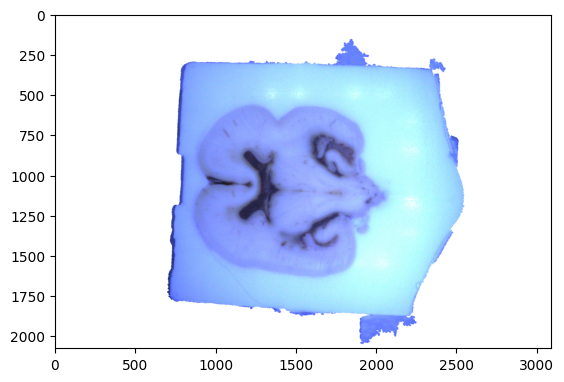

In [282]:
plt.imshow(blank_white)

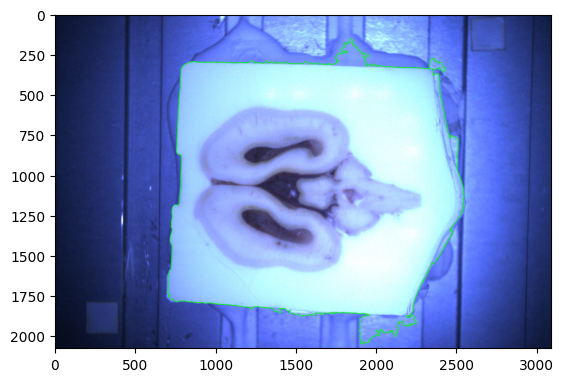

In [212]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)
img_copy = img.copy()
for i in range(1):
    cv2.drawContours(img_copy, contours, i, (0,255,0), 3)
plt.imshow(img_copy)

In [ ]:

plt.imshow(sample_img)
plt.axis('off')
plt.show()

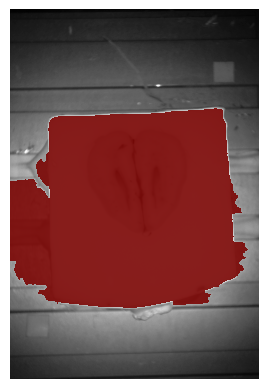

In [66]:
sample_ants = ants.from_numpy(sample_img)
sample_mask = sample_ants.get_mask(cleanup=2)
ants.plot(sample_ants, overlay=sample_mask)

In [87]:
#plot canny edges
edges.shape

(2076, 3088)

In [88]:
import numpy as np
import scipy.ndimage as ndi 
from skimage import feature

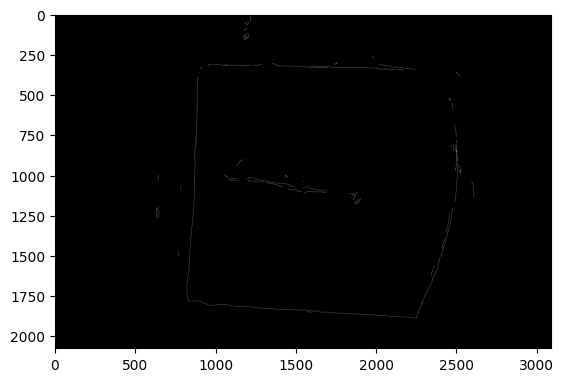

In [94]:
gaussian_img = ndi.gaussian_filter(sample_img.copy(), 2).copy()
edges = feature.canny(gaussian_img, sigma=0.02)
plt.imshow(edges, cmap='gray')

In [81]:
blank = np.ones_like(sample_img)
blank = cv2.drawContours(blank, [contours], -1, 0, 5)


In [83]:
[cv2.contourArea(c) for c in contours]

[6405509.5, 4.0, 4.0, 2.0, 6.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0]

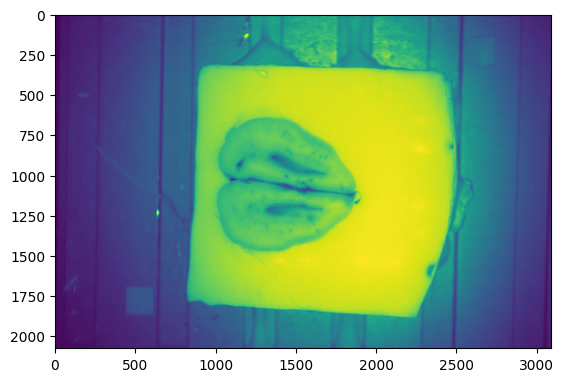

In [84]:
plt.imshow(sample_img)